Summary: The most prominent trend observed is that B predicts a lot more often the positive class (>4500 bike shares) than A. The exact reasons depend on temperature: There is a high chance for differences for instances with mid-range temp values, mnth values from march upwards and either good weathersit or bad weathersit and windspeed not too low. Furthermore, for instances with high temp values, mnth from may upwards, not too high atemp, not too low windspeed and high hum. Furthermore for instances with very high atemp.

In [47]:
import pandas as pd
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt
from IPython.display import display
from ast import literal_eval
from comparers import ModelComparer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from baseline import dt_feature_importance, get_rules
from tasks.bike_sharing import make_task
from diro2c_wrapper import CombinationClassifier, ConstantClassifier

XGBoost prints many warnings, that are safe to ignore:

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

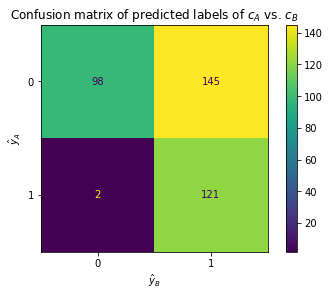

In [6]:
comparer.plot_confusion_matrix(X)

In [7]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [40]:
mclass_tree = DecisionTreeClassifier(max_depth=3)
mclass_tree.fit(X, mclass_diff)
class_names = comparer.class_names[mclass_tree.classes_]

In [41]:
feature_importances = dt_feature_importance(mclass_tree)
feature_order = np.flip(np.argsort(feature_importances))

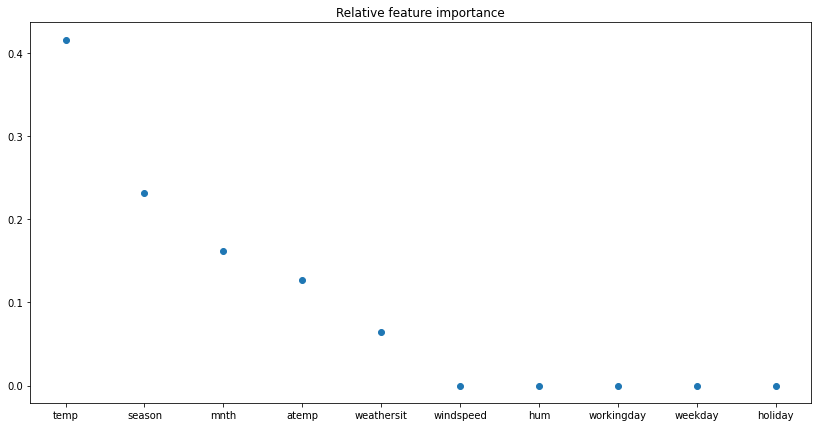

In [42]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [43]:
class_names

array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6')

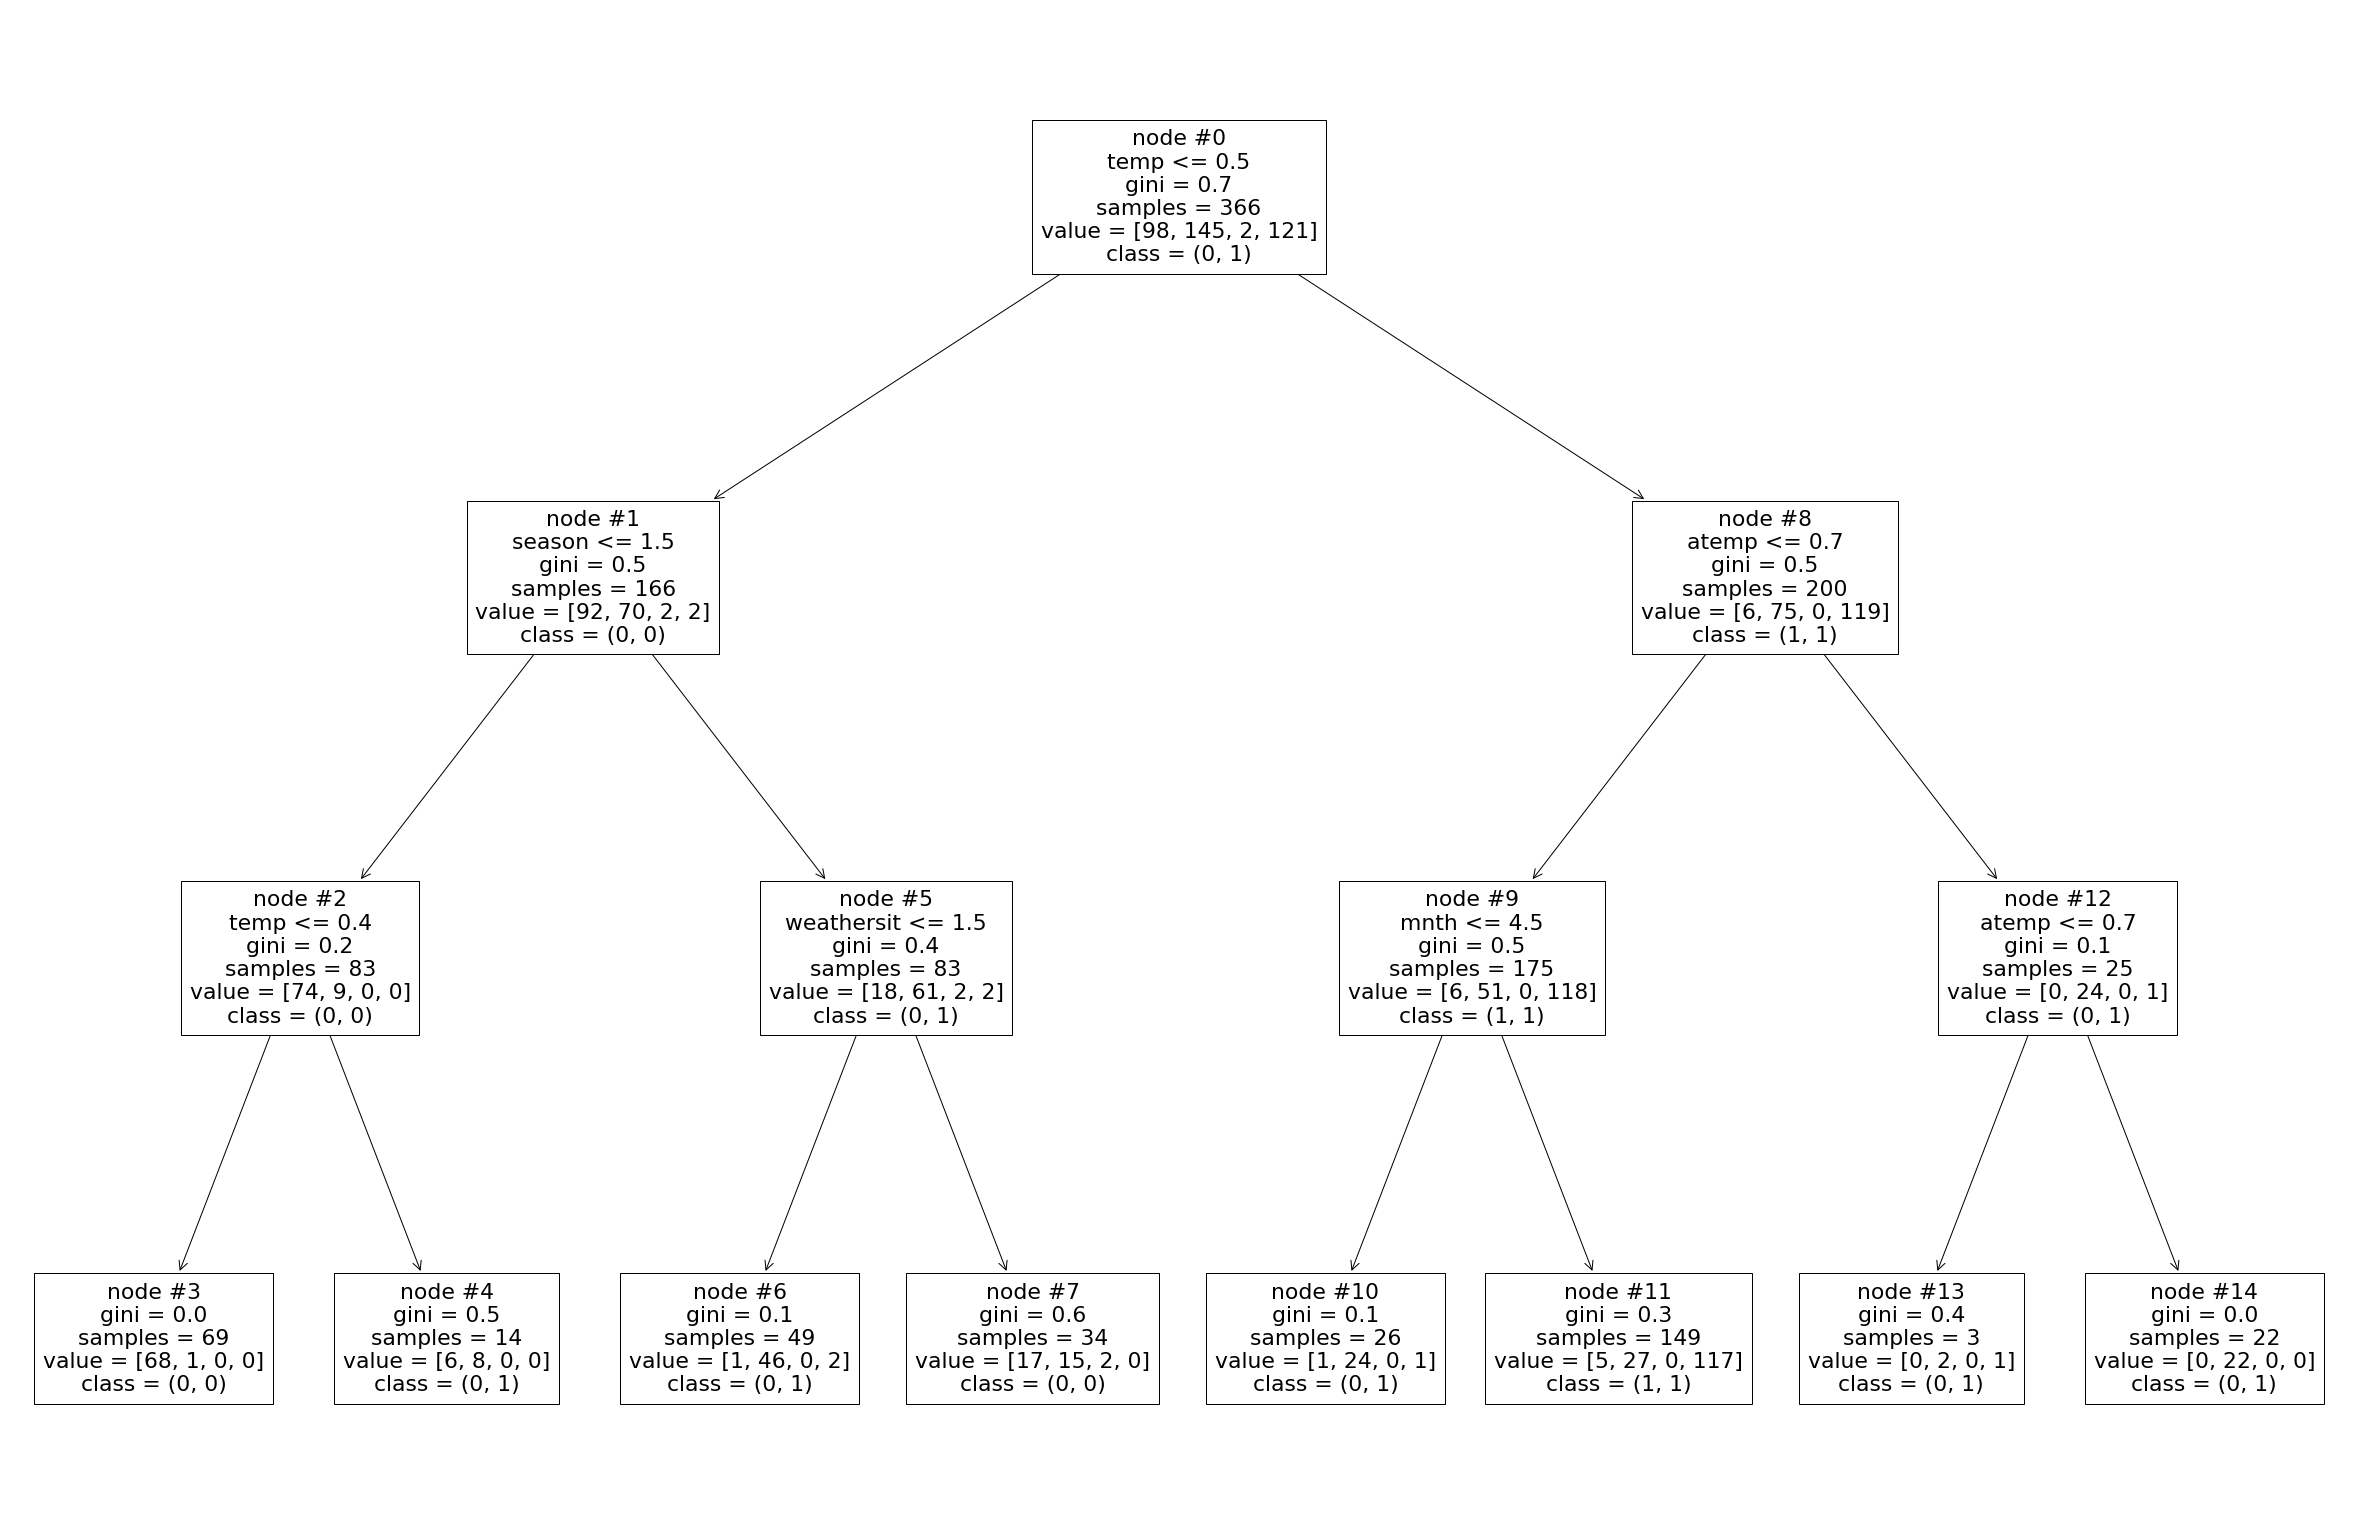

In [44]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [45]:
rules = get_rules(mclass_tree, feature_names, class_names, '(0, 1)', feature_order, precision=2)
[print(rule) for rule in rules];

if (temp <= 0.47) and (season > 1.5) and (weathersit <= 1.5) then class: (0, 1) (proba: 93.88%) | based on 49 samples
if (temp > 0.47) and (mnth <= 4.5) and (atemp <= 0.7) then class: (0, 1) (proba: 92.31%) | based on 26 samples
if (temp > 0.47) and (atemp > 0.71) then class: (0, 1) (proba: 100.0%) | based on 22 samples
if (temp > 0.39) and (temp <= 0.47) and (season <= 1.5) then class: (0, 1) (proba: 57.14%) | based on 14 samples
if (temp > 0.47) and (atemp > 0.7) and (atemp <= 0.71) then class: (0, 1) (proba: 66.67%) | based on 3 samples


In [46]:
rules = get_rules(mclass_tree, feature_names, class_names, '(1, 0)', feature_order, precision=2)
[print(rule) for rule in rules];

In [170]:
focus_class = '(0, 1)'

In [171]:
mclass_tree = DecisionTreeClassifier(max_depth=6)
mclass_tree.fit(X, CombinationClassifier(comparer, *literal_eval(focus_class)).predict(X))
class_names = np.array(['other', focus_class])

In [172]:
feature_importances = dt_feature_importance(mclass_tree)
feature_order = np.flip(np.argsort(feature_importances))

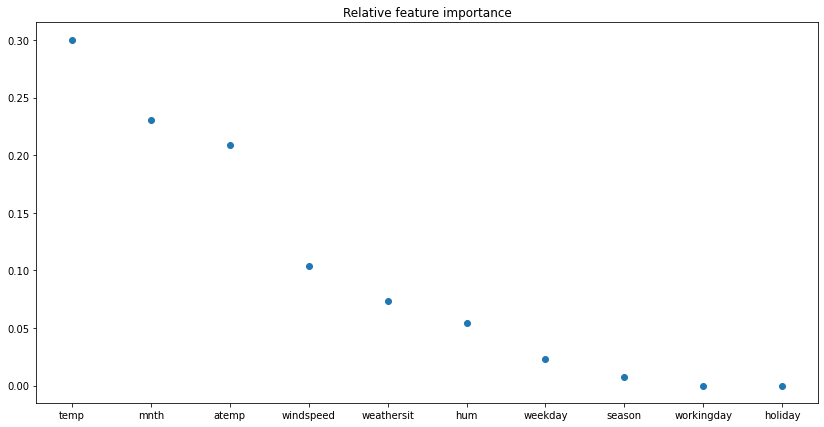

In [173]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [174]:
class_names

array(['other', '(0, 1)'], dtype='<U6')

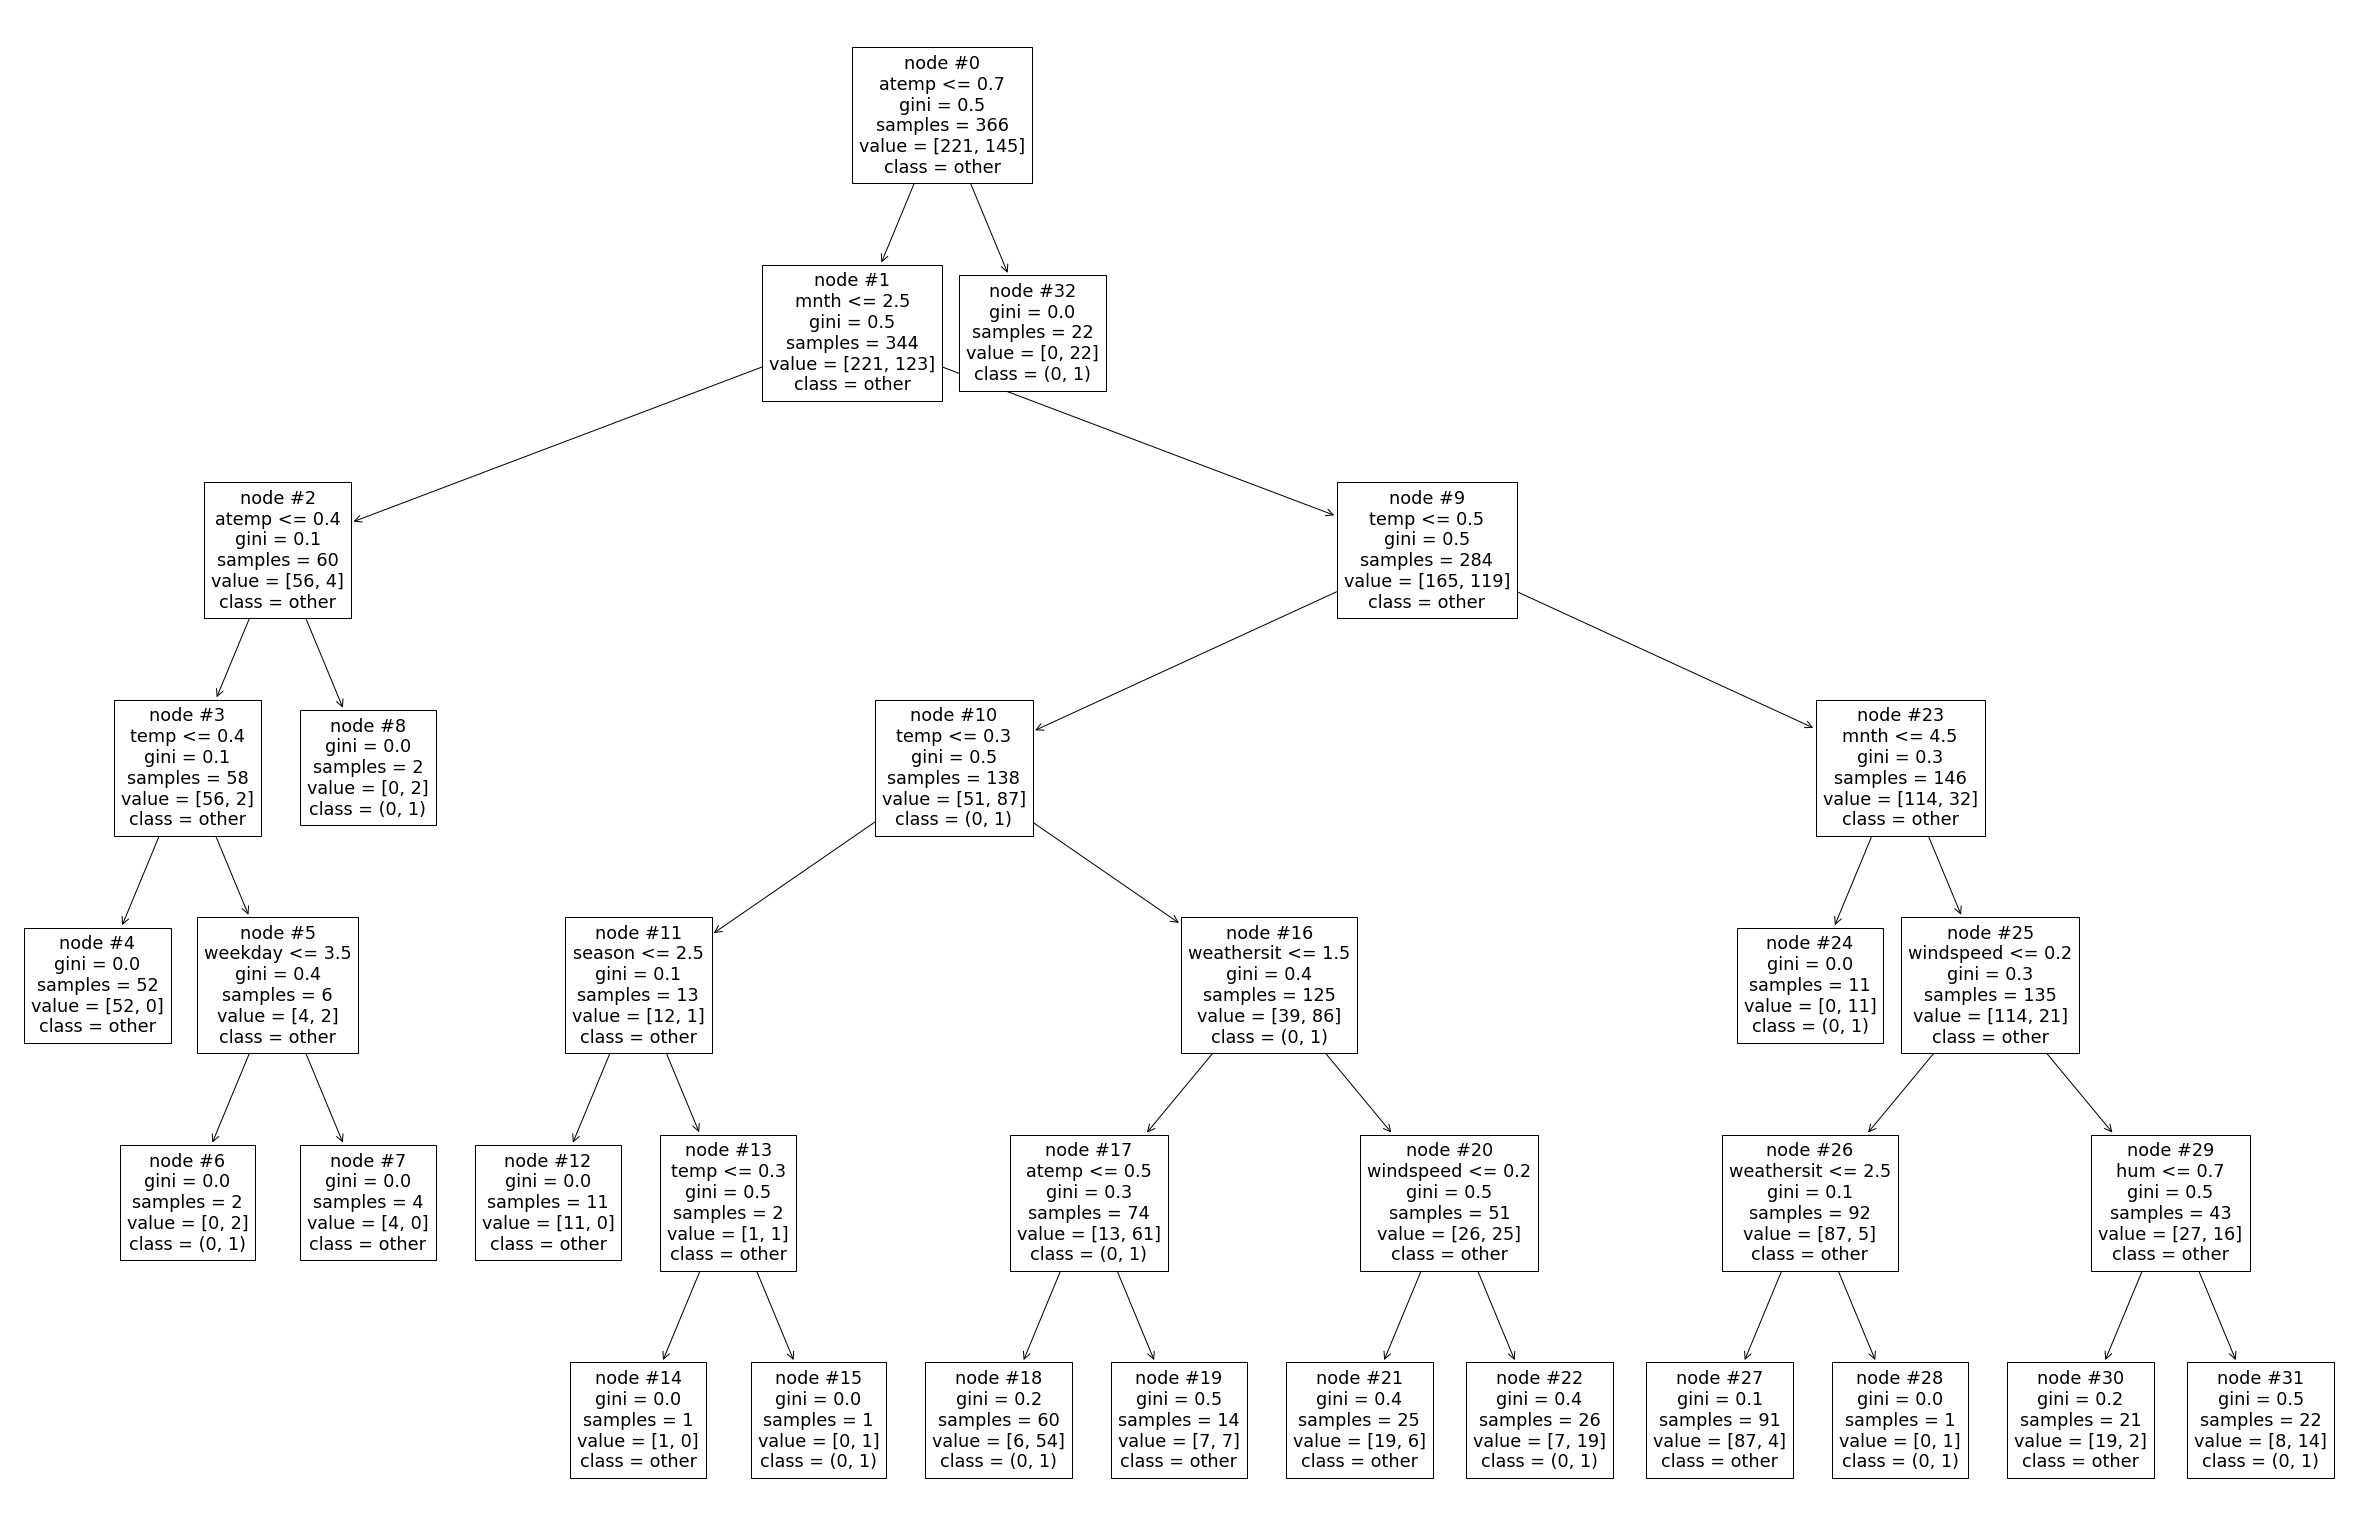

In [175]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [176]:
rules = get_rules(mclass_tree, feature_names, class_names, focus_class, feature_order, precision=2)
[print(rule) for rule in rules];

node #18: if (temp > 0.27) and (temp <= 0.54) and (mnth > 2.5) and (atemp <= 0.48) and (weathersit <= 1.5) then class: (0, 1) (54/60 instances)
node #22: if (temp > 0.27) and (temp <= 0.54) and (mnth > 2.5) and (atemp <= 0.71) and (windspeed > 0.17) and (weathersit > 1.5) then class: (0, 1) (19/26 instances)
node #31: if (temp > 0.54) and (mnth > 4.5) and (atemp <= 0.71) and (windspeed > 0.19) and (hum > 0.65) then class: (0, 1) (14/22 instances)
node #32: if (atemp > 0.71) then class: (0, 1) (22/22 instances)
node #24: if (temp > 0.54) and (mnth > 2.5) and (mnth <= 4.5) and (atemp <= 0.71) then class: (0, 1) (11/11 instances)
node #8: if (mnth <= 2.5) and (atemp > 0.43) and (atemp <= 0.71) then class: (0, 1) (2/2 instances)
node #6: if (temp > 0.39) and (mnth <= 2.5) and (atemp <= 0.43) and (weekday <= 3.5) then class: (0, 1) (2/2 instances)
node #28: if (temp > 0.54) and (mnth > 4.5) and (atemp <= 0.71) and (windspeed <= 0.19) and (weathersit > 2.5) then class: (0, 1) (1/1 instances)

The first four rules cover 109 of 145 instances. B predicts the positive class when A still predicts the negative class for instances with mid-range temp values, mnth values from march upwards and either good weathersit or bad weathersit and windspeed not too low. Furthermore, for instances with high temp values, mnth from may upwards, not too high atemp, not too low windspeed and high hum. Furthermore for instances with very high atemp.

In [83]:
focus_class = '(1, 0)'

In [164]:
mclass_tree = DecisionTreeClassifier(max_depth=6)
mclass_tree.fit(X, CombinationClassifier(comparer, *literal_eval(focus_class)).predict(X))
class_names = np.array(['other', focus_class])

In [165]:
feature_importances = dt_feature_importance(mclass_tree)
feature_order = np.flip(np.argsort(feature_importances))

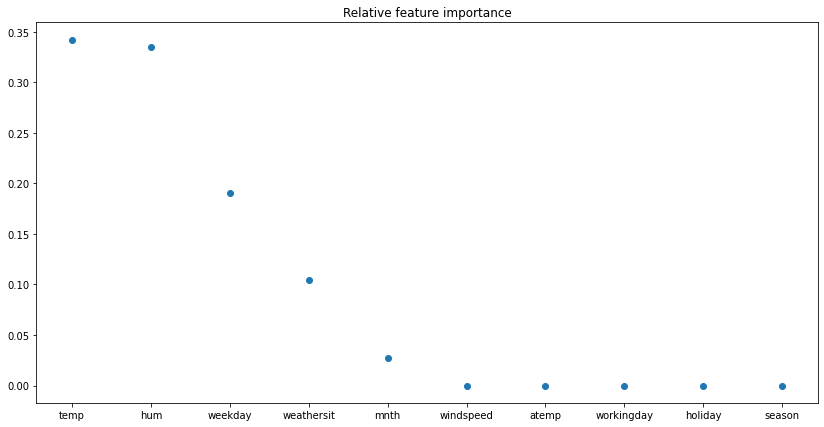

In [166]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [167]:
class_names

array(['other', '(1, 0)'], dtype='<U6')

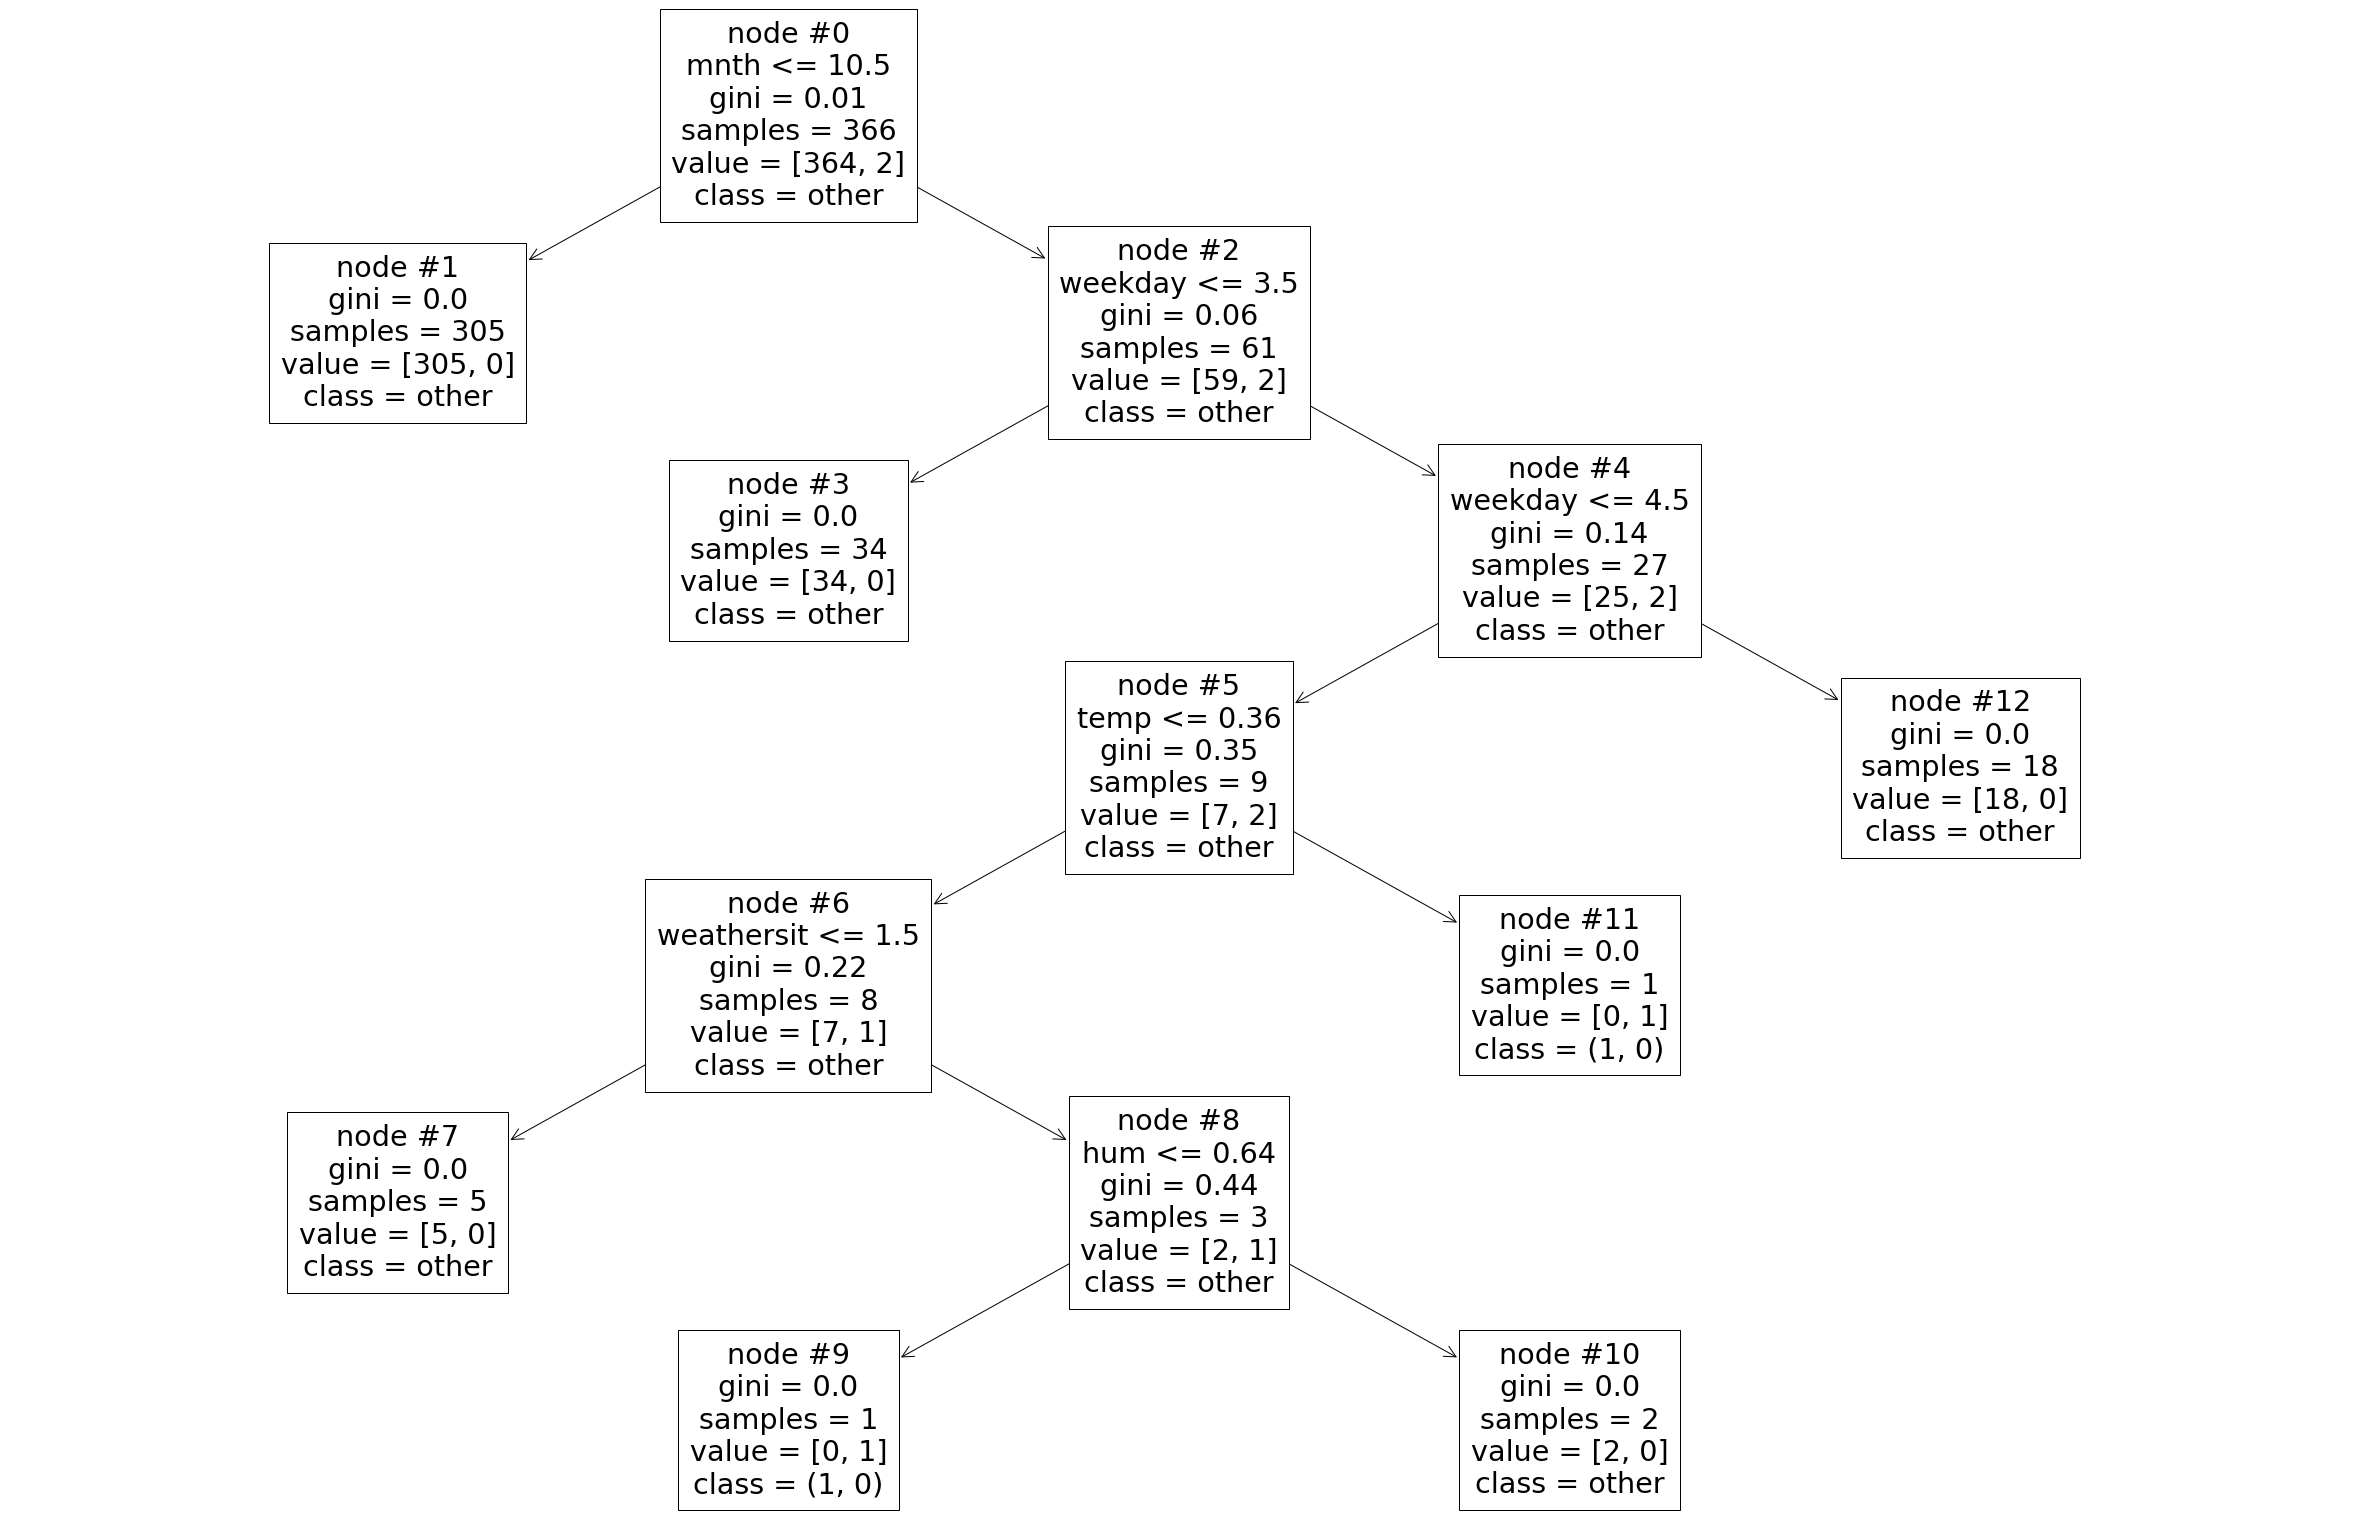

In [168]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=2, node_ids=True);

In [169]:
rules = get_rules(mclass_tree, feature_names, class_names, focus_class, feature_order, precision=2)
[print(rule) for rule in rules];

node #11: if (temp > 0.36) and (weekday > 3.5) and (weekday <= 4.5) and (mnth > 10.5) then class: (1, 0) (1/1 instances)
node #9: if (temp <= 0.36) and (hum <= 0.64) and (weekday > 3.5) and (weekday <= 4.5) and (weathersit > 1.5) and (mnth > 10.5) then class: (1, 0) (1/1 instances)


A predicts the positive class where B still predicts the negative class in just 2 cases. This happens when mnth is November or December, weekday is thursday and either temp not very low or temp very low, hum not too high and bad weathersit.

In [163]:
from importlib import reload
import baseline
reload(baseline)
from baseline import get_rules